### GAN PART-1

### **Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo**


In [9]:
#imoorting necessary libraries
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose

In [1]:
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
                              train=True,
                              download=True,
                              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:01<00:00, 14191060.46it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268201.01it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5026715.48it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6014561.84it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [2]:
# Accessing an image and its label
img, label = fashion_mnist[0]
print('Label: ', label)
print('Image shape:', img.shape)
print(img[:, 10:15, 10:15])  # Displaying a portion of the image
print('Minimum pixel value:', torch.min(img))
print('Maximum pixel value:', torch.max(img))

Label:  9
Image shape: torch.Size([1, 28, 28])
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])
Minimum pixel value: tensor(-1.)
Maximum pixel value: tensor(1.)


 Here in this output ,

 label indicates the class/category of the image and in this case the label is 9, which corresponds to the class "Ankle boot.

 The shape of the image tensor is [1, 28, 28], means it's a grayscale image with a height and width of 28 pixels each.

 A portion of image is displayed as 5x5 grid of pixel values which have been normalised to be in range [-1,1].

 And also, the minimum pixel value in the normalized image tensor is -1 and maximum pixel value in the normalized image tensor is 1.

In [6]:
#denormalising the image as this will be useful to view the gerenrated images

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


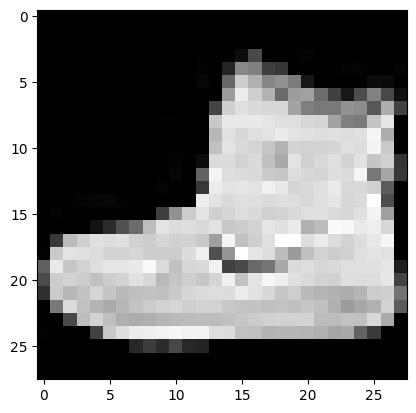

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

norm_img = denorm(img)
plt.imshow(norm_img[0], cmap='gray')
print('Label:', label)

**Creating a dataloader to load the images in batches**

In [12]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([3, 0, 1, 2, 9, 0, 0, 6, 1, 3, 1, 1, 3, 3, 1, 1, 6, 4, 6, 9, 1, 9, 2, 2,
        8, 5, 2, 3, 1, 8, 2, 0, 3, 0, 0, 0, 5, 2, 3, 1, 3, 0, 8, 0, 9, 6, 6, 0,
        9, 7, 3, 3, 0, 9, 3, 5, 0, 6, 1, 7, 1, 9, 6, 0, 4, 6, 4, 7, 5, 3, 7, 5,
        2, 1, 6, 0, 7, 6, 2, 4, 4, 2, 9, 8, 0, 9, 8, 5, 5, 5, 9, 4, 0, 9, 0, 1,
        7, 5, 3, 7])


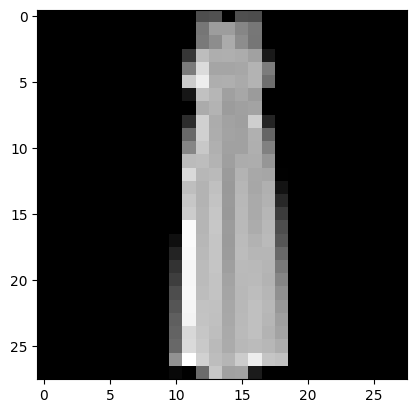

In [13]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [15]:
#creating a device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

### **Step2. Train the GAN model to produce images in this new domain.**

**Discriminator Network**

In [16]:
image_size = 784
hidden_size = 256

import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [17]:
D.to(device);

**Generator Network**

In [18]:
latent_size = 64

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [19]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

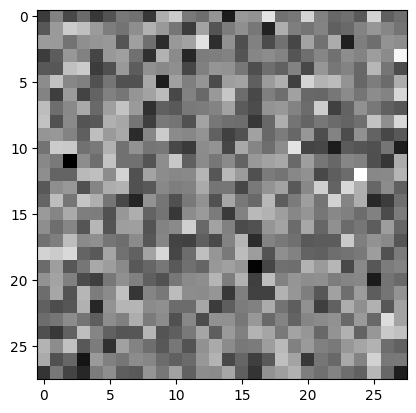

In [20]:
plt.imshow(gen_imgs[0], cmap='gray');

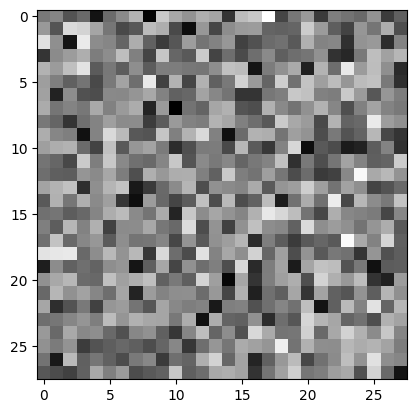

In [21]:
plt.imshow(gen_imgs[1], cmap='gray');

In [22]:
G.to(device);

**Discriminator Training**

In [23]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [24]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

**Generator Training**

In [25]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [26]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

**Training the Model**

Creating a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model

In [27]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Saving a batch of real images that we can use for visual comparision while looking at the generated images.

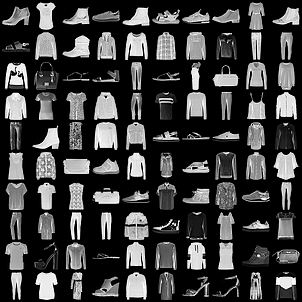

In [28]:
from IPython.display import Image
from torchvision.utils import save_image

for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Defining a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


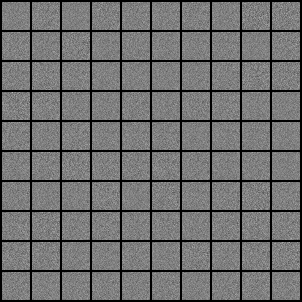

In [29]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

Ready to train the model.

In each epoch, training the discriminator first, and then the generator.

In [30]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0486, g_loss: 4.3071, D(x): 0.98, D(G(z)): 0.03
Epoch [0/300], Step [400/600], d_loss: 0.1300, g_loss: 6.1204, D(x): 0.96, D(G(z)): 0.06
Epoch [0/300], Step [600/600], d_loss: 0.0876, g_loss: 4.8257, D(x): 0.95, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0289, g_loss: 4.6263, D(x): 0.99, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.0902, g_loss: 4.0322, D(x): 0.98, D(G(z)): 0.04
Epoch [1/300], Step [600/600], d_loss: 0.0413, g_loss: 5.7052, D(x): 0.98, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0144, g_loss: 5.7523, D(x): 1.00, D(G(z)): 0.01
Epoch [2/300], Step [400/600], d_loss: 0.0469, g_loss: 5.5260, D(x): 0.99, D(G(z)): 0.03
Epoch [2/300], Step [600/600], d_loss: 0.0274, g_loss: 5.8602, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0273, g_loss: 8.1930, D(x): 1.00, D(G(z)): 0.02
Epoch [3/300], Step [400/6

### Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

Saving fake_images-0000.png
Saving fake_images-0001.png
Saving fake_images-0002.png


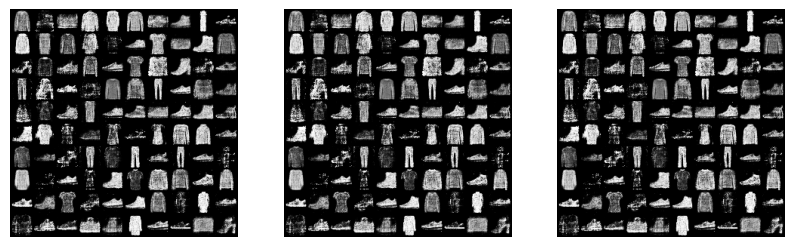

In [31]:
# After training the model, saving and display generated samples
# Sample and save 3 images

for i in range(3):
    save_fake_images(i)

# Displaying the saved images
import matplotlib.pyplot as plt
import PIL

# Plotting the saved images
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    img_path = os.path.join(sample_dir, f'fake_images-000{i}.png')
    img = PIL.Image.open(img_path)
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()


Difficulties faced in the process:

Assessing the quality of the created samples has been pretty tough and subjective. While looking at them gives some insight, it doesn't always cover all aspects of sample quality. It's been hard to figure out if the generated samples really match the desired distribution or successfully represent the variety in the dataset.

Saving and displaying generated samples has been quite challenging. Managing image data and file handling has proven to be tricky, as incorrect handling could lead to opening unintended image files for visualization. I've encountered difficulties in accurately saving the generated images to disk and organizing them for display. Ensuring that the saved images faithfully represent the generated samples has also been a concern. It's been a learning process to address these challenges and ensure that the displayed images accurately reflect the output of the GAN model.

Generating high-quality samples from the GAN model has been tough.The quality of the generated samples changes based on how the generator and discriminator are set up, and it also depends on how the training process is carried out. I've had some trouble making sharp, detailed samples that really look like the original images. Blurriness and missing small details have been pretty common problems, which shows just how tricky it is to get good sample quality.

Also,training the model for 300 epochs turned out to be really time-consuming. It took around 3 hours to finish, and because I didn't have a GPU, my system kept crashing during training and i had to restart from the beginning multiple times, making the whole process take even longer.

### **Step4. Save the model weights in the folder to be used later.**

In [33]:
# After training, saving the model weights
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')

This will save the state dictionaries of both the generator and discriminator networks into files named 'generator.pth' and 'discriminator.pth', respectively

### **Step5. Load the model using the saved weights.**

Loading the model by using the saved weights

In [34]:
#Defining Generator and Discriminator networks
latent_size = 64
hidden_size = 256
image_size = 784


# Loading the saved weights
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
G.load_state_dict(torch.load('generator.pth'))  #loaded with saved weights
G.eval()

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D.load_state_dict(torch.load('discriminator.pth'))    #loaded with saved weights
D.eval()


Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

### **Step 6: Re-train the GAN model to see if you can improve.**

In [35]:
# Defining the loss function and optimizers for both discriminator and generator
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [37]:
# Setting the number of epochs and other parameters
num_epochs = 100
sample_interval = 200

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Moving images to device
        images = images.reshape(batch_size, -1).to(device)

        # Training the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)

        # Training the generator
        g_loss, fake_images = train_generator()

        # Printing losses and scores
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch+1, num_epochs, i+1, len(data_loader), d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

        # Saving generated images at specified intervals
        if (i+1) % sample_interval == 0:
            save_fake_images(epoch * len(data_loader) + i + 1)

Epoch [1/100], Step [200/600], d_loss: 1.2266, g_loss: 1.2139, D(x): 0.65, D(G(z)): 0.43
Saving fake_images-0200.png
Epoch [1/100], Step [400/600], d_loss: 1.0552, g_loss: 1.2999, D(x): 0.67, D(G(z)): 0.36
Saving fake_images-0400.png
Epoch [1/100], Step [600/600], d_loss: 0.9804, g_loss: 1.7312, D(x): 0.65, D(G(z)): 0.28
Saving fake_images-0600.png
Epoch [2/100], Step [200/600], d_loss: 0.9423, g_loss: 1.4871, D(x): 0.71, D(G(z)): 0.33
Saving fake_images-0800.png
Epoch [2/100], Step [400/600], d_loss: 0.9790, g_loss: 1.4473, D(x): 0.63, D(G(z)): 0.29
Saving fake_images-1000.png
Epoch [2/100], Step [600/600], d_loss: 1.0819, g_loss: 1.1950, D(x): 0.68, D(G(z)): 0.36
Saving fake_images-1200.png
Epoch [3/100], Step [200/600], d_loss: 0.9241, g_loss: 1.4135, D(x): 0.67, D(G(z)): 0.30
Saving fake_images-1400.png
Epoch [3/100], Step [400/600], d_loss: 1.1080, g_loss: 1.4245, D(x): 0.65, D(G(z)): 0.36
Saving fake_images-1600.png
Epoch [3/100], Step [600/600], d_loss: 0.8547, g_loss: 1.4831, D

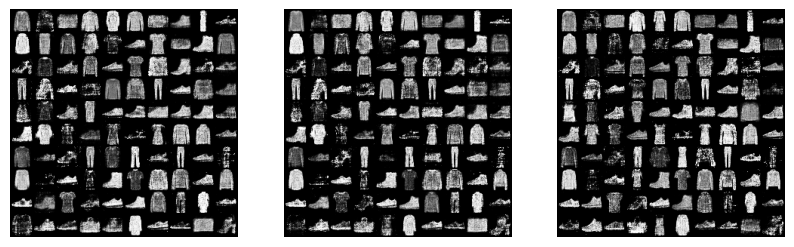

In [39]:
import matplotlib.pyplot as plt
import PIL

# Display the three specified generated images
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# List of filenames corresponding to the specified checkpoints
filenames = ['fake_images-1200.png', 'fake_images-14000.png', 'fake_images-59600.png']

for i, filename in enumerate(filenames):
    # Load the image
    img_path = f'samples/{filename}'
    img = PIL.Image.open(img_path)

    # Display the image
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()


### **Step 7: Save the model weights without using checkpoints.**

In [40]:
# Saving the generator and discriminator model weights without using checkpoints
torch.save(G.state_dict(), 'generator_weights.pth')
torch.save(D.state_dict(), 'discriminator_weights.pth')

### **Step 8: Load the model weights without using checkpoints.**

In [41]:
# Defining Generator and Discriminator networks
latent_size = 64
hidden_size = 256
image_size = 784

# Defining new instances of Generator and Discriminator networks
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Loading the saved weights without using checkpoints
G.load_state_dict(torch.load('generator_weights.pth'))
D.load_state_dict(torch.load('discriminator_weights.pth'))

# Setting models to evaluation mode
G.eval()
D.eval()


Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)